In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load population dataset

In [6]:
def parse_population_data(path):
    """Parse population data from csv file and return a dataframe
    """
    df = pd.read_excel(path)
    
    # Drop the first 15 rows and set the first row as the header
    df = df.iloc[15:]
    
    # Set the first row as the header
    df = df.rename(columns=df.iloc[0]).drop(df.index[0])
    
    # Select the columns of interest
    df = df[['Region, subregion, country or area *', 'ISO3 Alpha-code', 'Year', 'Total Population, as of 1 January (thousands)', 'Life Expectancy at Birth, both sexes (years)']]
    
    return df

df_pop = parse_population_data('dataset\WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx')  # Source: https://population.un.org/wpp/Download/Standard/MostUsed/

# Load Powerty and Inequality Platform dataset

In [8]:
def parse_pip(path):
    """Parse the PIP dataset to a dataframe"""
    df = pd.read_csv(path)
    
    # Keep only national data (remove rural or urban only data)
    df = df[df['reporting_level'] == 'national']
    
    # Drop duplicates having welfare_type = "consumption"
    df = df[~((df[['country_name', 'country_code', 'reporting_year']].duplicated(keep=False)) &
              (df['welfare_type'] == "consumption"))
            ].reset_index(drop=True)
    
    # Keep only relevant columns and rename it
    df = df[['region_name', 'region_code', 'country_name', 'country_code', 'reporting_year', 'headcount']]
    df.rename(columns={'reporting_year':'year'}, inplace=True)

    return df
  
  
  # Load the population dataset. Source: https://pip.worldbank.org/
df_pip = parse_pip('dataset\pip.csv')

# Create a dataframe that links country to region
df_region_country = df_pip[['region_name','region_code','country_name','country_code']].drop_duplicates()

# Create the main dataframe to store all results

In [114]:
def get_share_of_population_below_2_15_a_day(df, df_pip):
    """Add the interpolated share of population below 2.15$ a day to the main dataframe"""

    df = df.merge(
        df_pip, 
        how='left', 
        on=['region_name', 'region_code', 'country_name', 'country_code', 'year'],
        validate='one_to_one'
        )

    df['share of population below 2.15$ a day'] = (
        df[['country_name', 'headcount']]
        .groupby('country_name')
        .transform(lambda x: x.interpolate(
            method='linear', 
            limit_area=None, 
            limit_direction='forward')
                   )
        )
    
    df.drop(columns=['headcount'], inplace=True)
    
    return df


def get_population_below_2_15_a_day(df, df_pop):
    """Add the interpolated population below 2.15$ a day to the main dataframe"""

    df['Total Population (thousands)'] = df.merge(
        df_pop.loc[~df_pop['ISO3 Alpha-code'].isna()],
        how='left',
        left_on=['country_code', 'year'],
        right_on=['ISO3 Alpha-code', 'Year'],
        validate='one_to_one'
        )['Total Population, as of 1 January (thousands)'].astype(float)

    df['population below 2.15$ a day (thousands)'] = df['share of population below 2.15$ a day'] * df['Total Population (thousands)']
    
    # df.drop(columns=['Total Population (thousands)'], inplace=True)
    
    return df


def plot_population_below_2_15_a_day(df):
    """Plot the population below 2.15$ a day for different regions and years"""
    
    sns.set_theme(style='darkgrid')

    # Grouping by region and year
    df_grouped = df.dropna().groupby(['region_name', 'year']).sum(numeric_only=True)
    df_grouped.reset_index(inplace=True)
    
    # Sum up all regions to get the world data
    complete_years = df_grouped.groupby('year').filter(lambda x: x['region_name'].nunique() == df['region_name'].nunique())
    df_world = complete_years.groupby('year').sum(numeric_only=True).reset_index()
    df_world['region_name'] = 'World'
    df_grouped = pd.concat([df_grouped, df_world])
    
    # Calculate the share of population below 2.15$ a day
    df_grouped['share of population below 2.15$ a day'] = df_grouped['population below 2.15$ a day (thousands)'] / df_grouped['Total Population (thousands)'] * 100
    
    # Plot the responses for different events and regions
    plot = sns.lineplot(x='year', y='share of population below 2.15$ a day',
                hue='region_name', data=df_grouped)
    plot.figure.set_size_inches(15, 8)
    plot.set_xlabel('Year', fontsize=12)
    plot.set_ylabel('Share of Population (%)', fontsize=12)
    plot.set_title('Share of Population Living Below 2.15$ a Day', fontsize=16)
    plot.legend(loc='upper left', frameon=True)
    plot.set_aspect('auto')
    plot.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

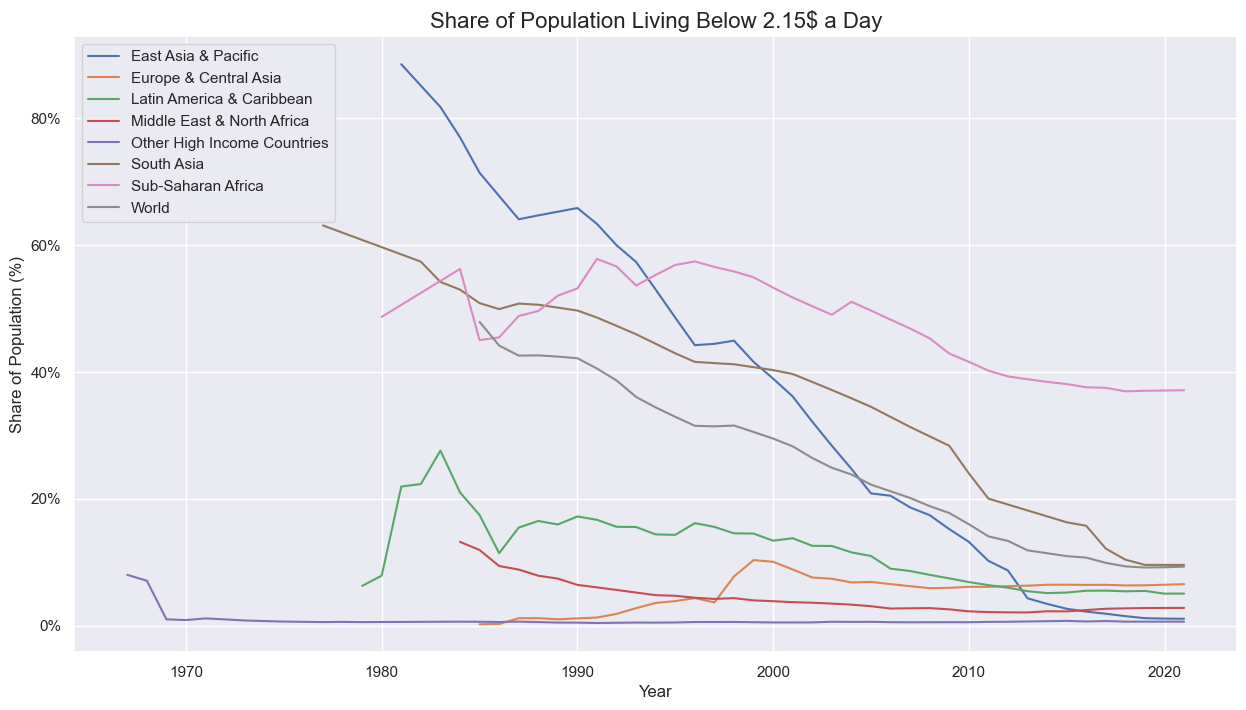

In [115]:
# Create the main dataframe to store all results
import matplotlib.ticker as mtick
df = pd.DataFrame(columns=['region_name', 'region_code', 'country_name', 'country_code'])
for year in range(1900, 2023):
    df_ = df_region_country.copy()
    df_['year'] = year
    df = pd.concat([df, df_])
df['year'] = df['year'].astype(int)

df = get_share_of_population_below_2_15_a_day(df, df_pip)
df = get_population_below_2_15_a_day(df, df_pop)
plot_population_below_2_15_a_day(df)

The graph reveals that all trends indicate a decrease. Despite this, approximately 10% of the population still lives in extreme poverty. In 1990, this number was above 40%. The largest decrease in poverty is observed in Asia, which makes up the majority of the population and has seen a rapid reduction in poverty. Africa presents difficulties in collecting data, with some countries lacking data for each year, leading to a flat trend after 2015 based on the most recent known data. The apparent increase in poverty in "Europe & Central Asia" countries could be attributed to the limited data before 1995, with only 7 countries having data in 1991 and 25 countries in 1998.

In [125]:
# List the years where the data where there is data for each country
df_pip[df_pip['region_name'] == 'Europe & Central Asia'].groupby('country_name')['year'].apply(list)

country_name
Albania                   [1996, 2002, 2005, 2008, 2012, 2014, 2015, 201...
Armenia                   [1996, 1999, 2001, 2002, 2003, 2004, 2005, 200...
Azerbaijan                             [1995, 2001, 2002, 2003, 2004, 2005]
Belarus                   [1993, 1995, 1998, 1999, 2000, 2001, 2002, 200...
Bosnia and Herzegovina                             [2001, 2004, 2007, 2011]
Bulgaria                  [1989, 1992, 1994, 1995, 1997, 2001, 2003, 200...
Croatia                   [1988, 1998, 1999, 2000, 2001, 2004, 2008, 200...
Czech Republic            [1992, 1993, 1996, 2002, 2004, 2005, 2006, 200...
Estonia                   [1993, 1995, 1998, 2000, 2001, 2002, 2003, 200...
Georgia                   [1996, 1997, 1998, 1999, 2000, 2001, 2002, 200...
Hungary                   [1987, 1989, 1991, 1993, 1994, 1998, 1999, 200...
Kazakhstan                [1993, 1996, 2001, 2002, 2003, 2004, 2005, 200...
Kosovo                    [2003, 2005, 2006, 2009, 2010, 2011, 2012, 201...

In [144]:
df[df['region_name'] == 'Europe & Central Asia'].groupby('year').count().tail(50)

,region_name,region_code,country_name,country_code,share of population below 2.15$ a day,Total Population (thousands),population below 2.15$ a day (thousands)
year,,,,,,,
1973,30,30,30,30,0,30,0
1974,30,30,30,30,0,30,0
1975,30,30,30,30,0,30,0
1976,30,30,30,30,0,30,0
1977,30,30,30,30,0,30,0
1978,30,30,30,30,0,30,0
1979,30,30,30,30,0,30,0
1980,30,30,30,30,0,30,0
1981,30,30,30,30,0,30,0


<AxesSubplot: xlabel='year'>

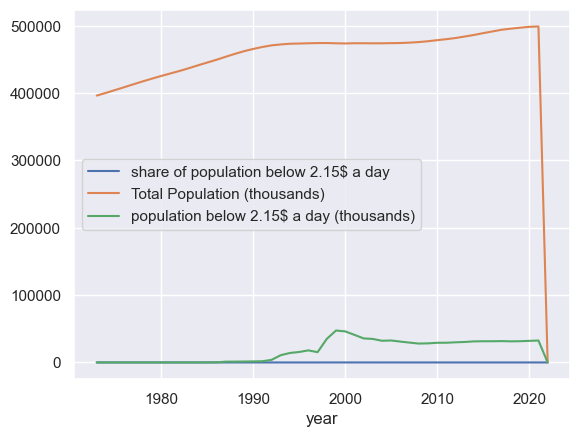

In [132]:
df[df['region_name'] == 'Europe & Central Asia'].groupby(['year']).sum(numeric_only=True).tail(50).plot()

c:\Users\rzfxxf\Anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


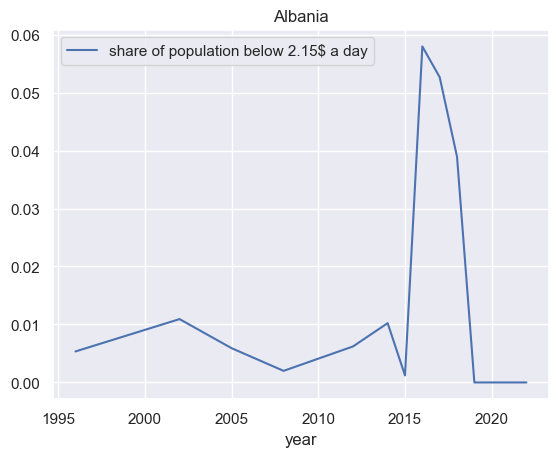

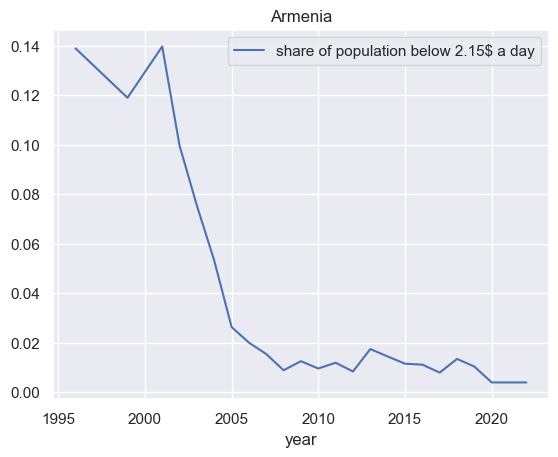

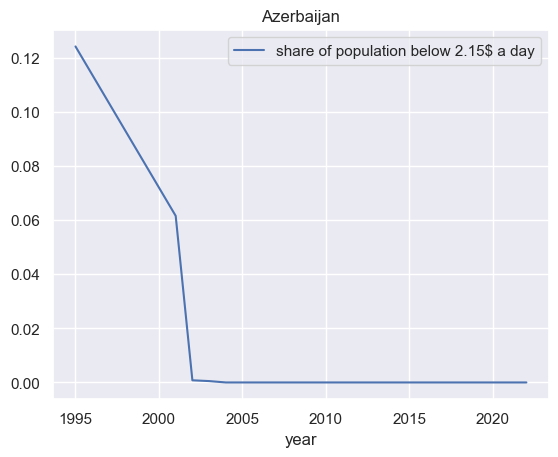

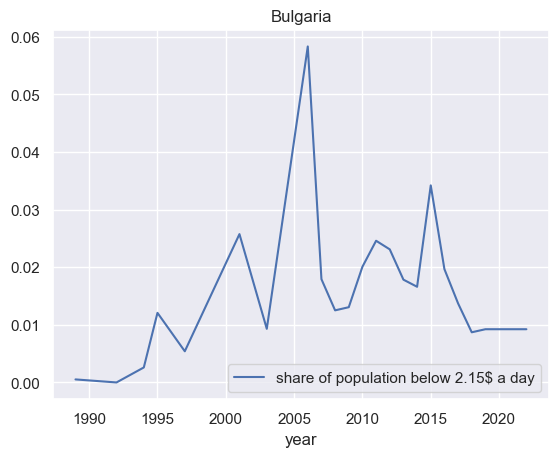

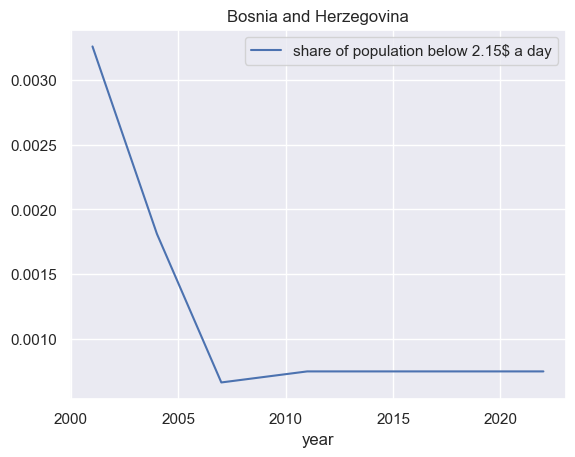

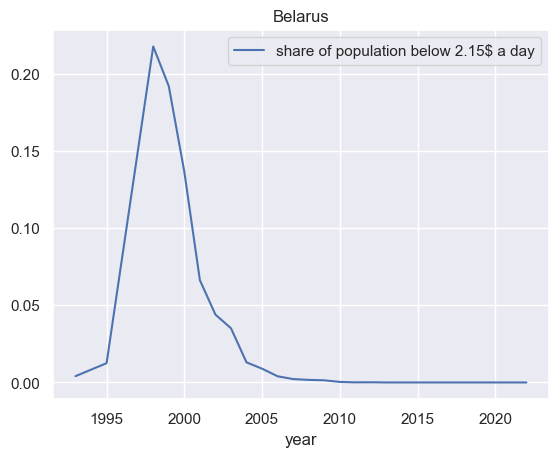

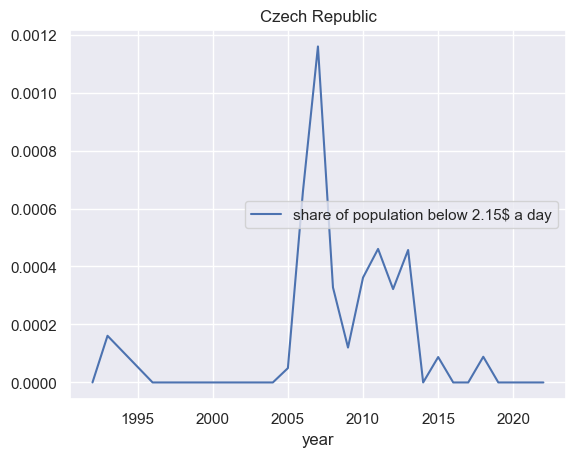

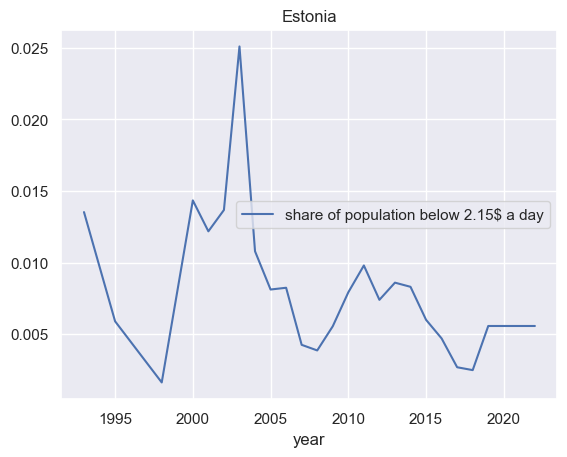

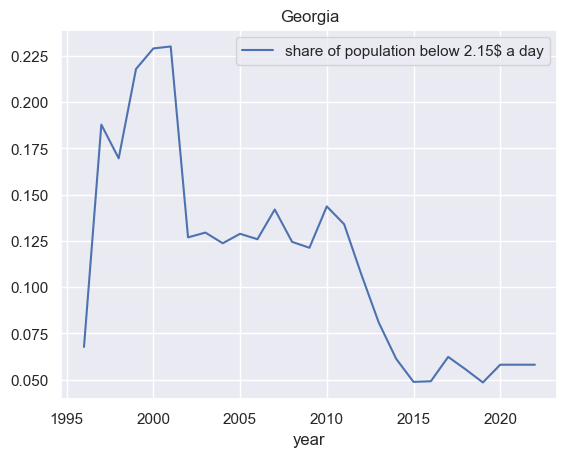

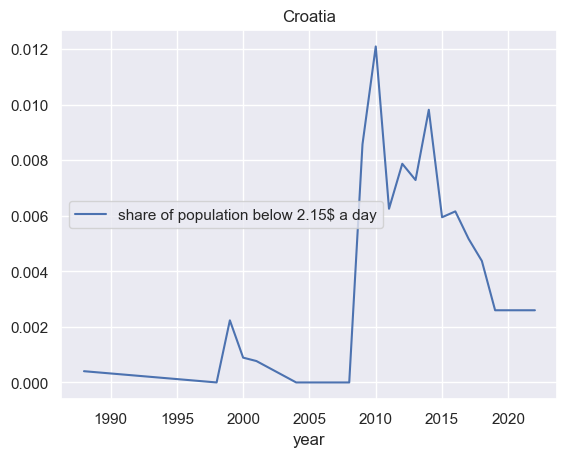

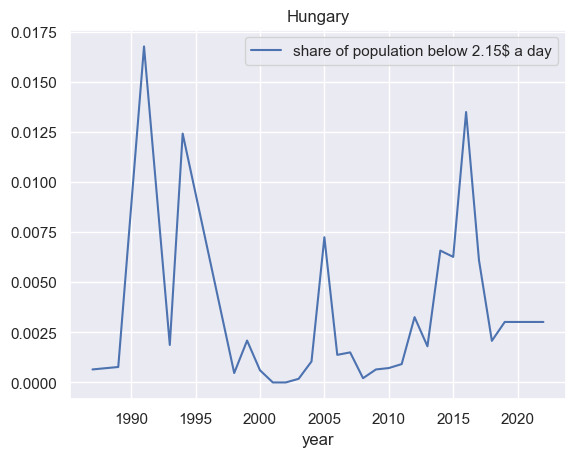

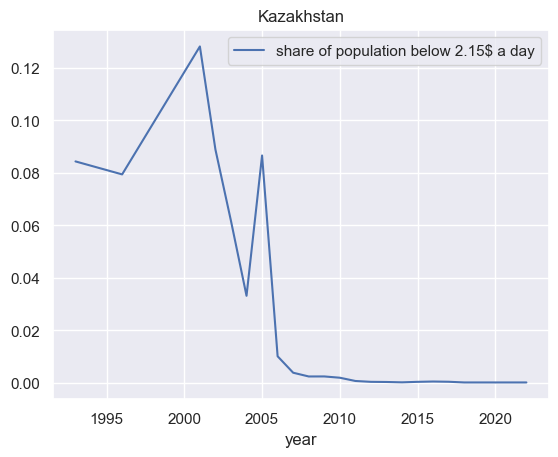

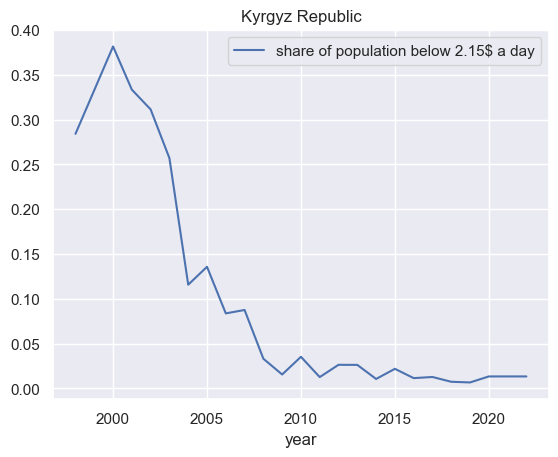

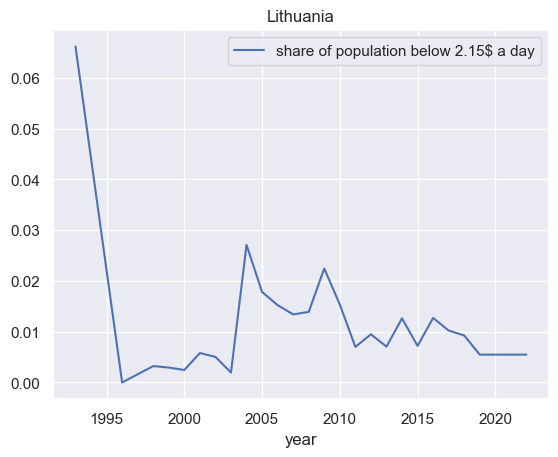

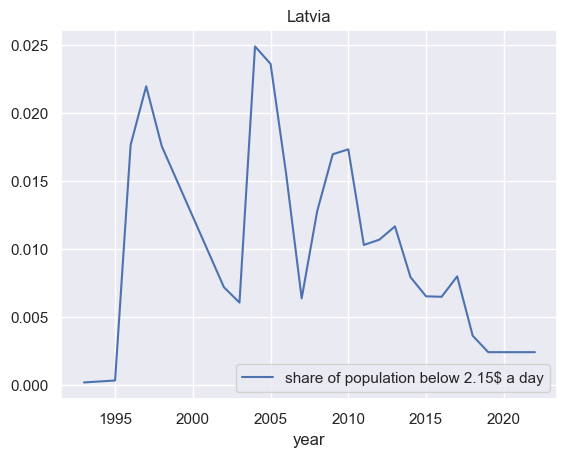

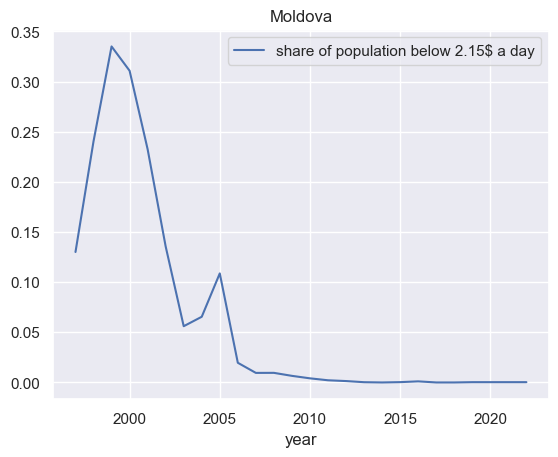

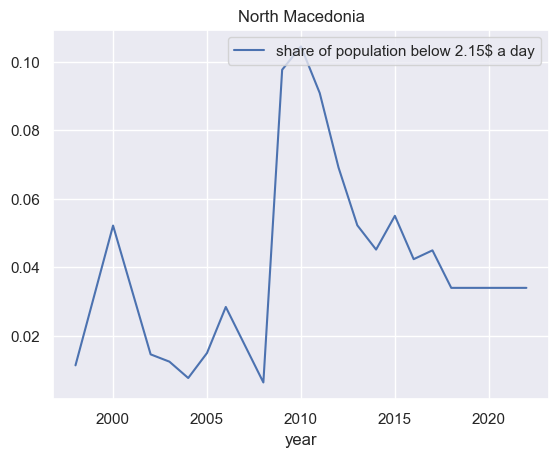

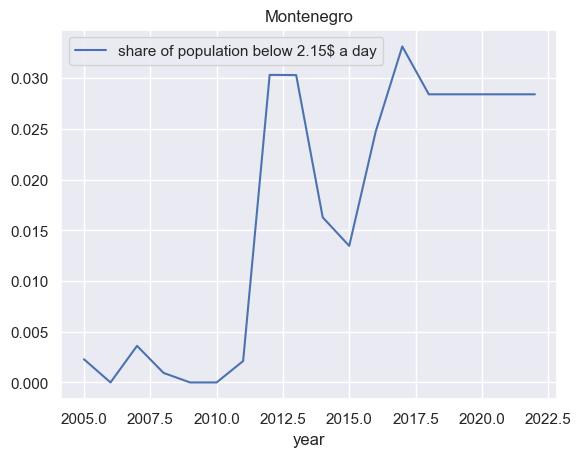

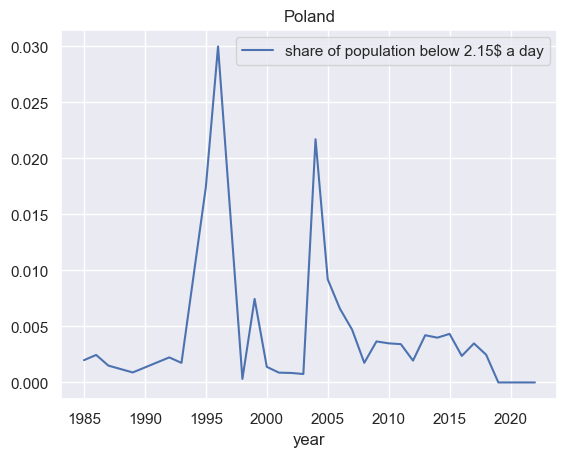

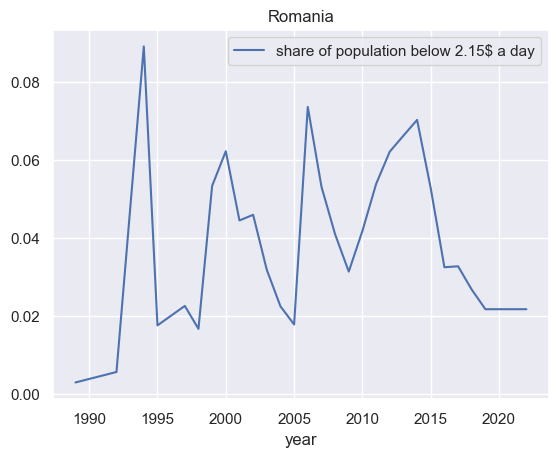

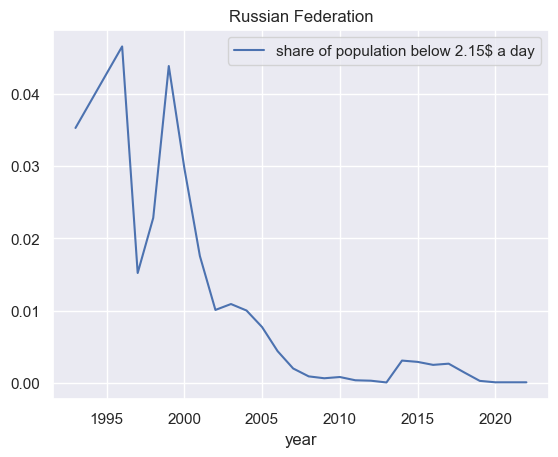

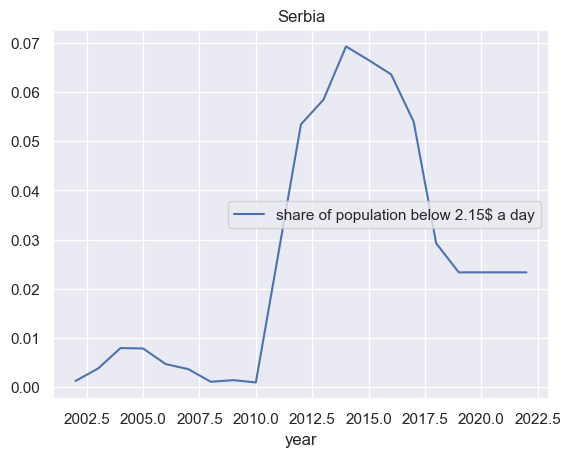

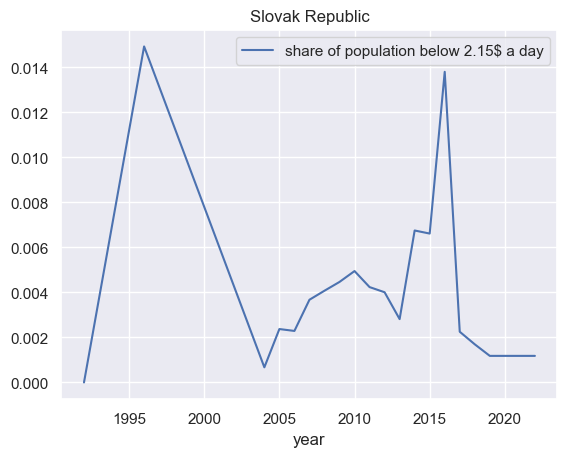

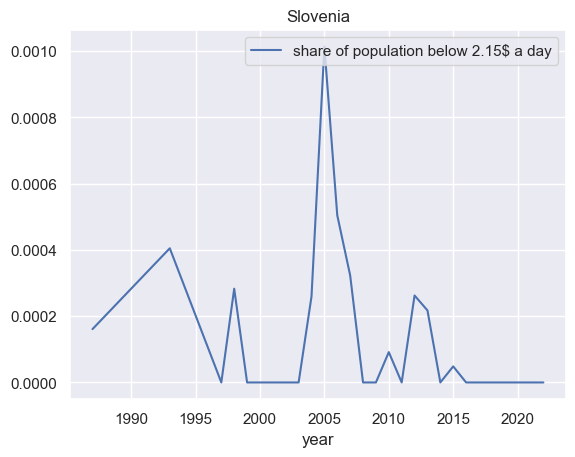

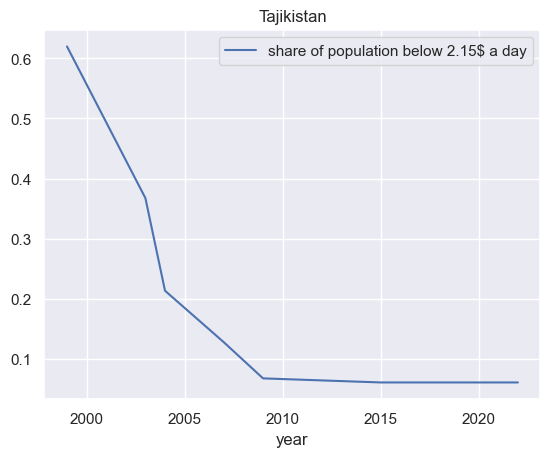

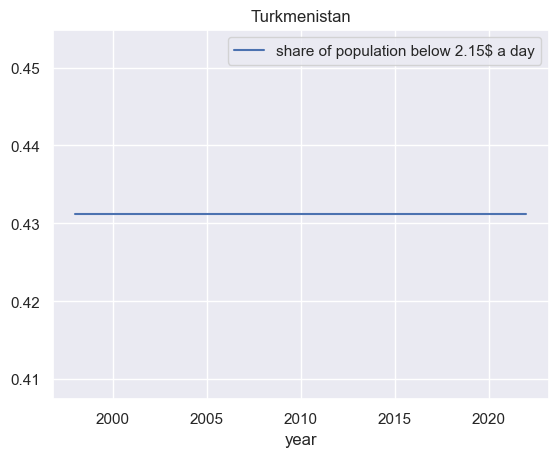

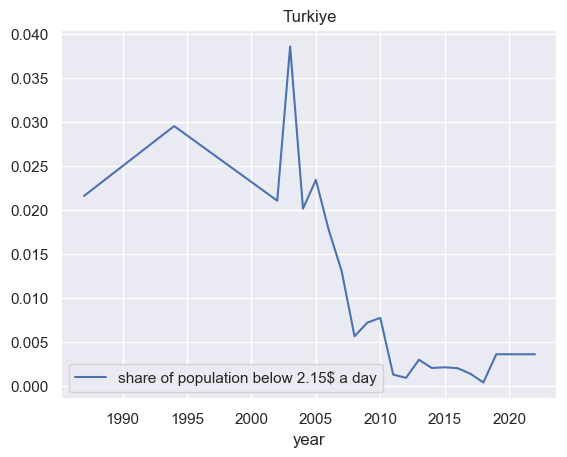

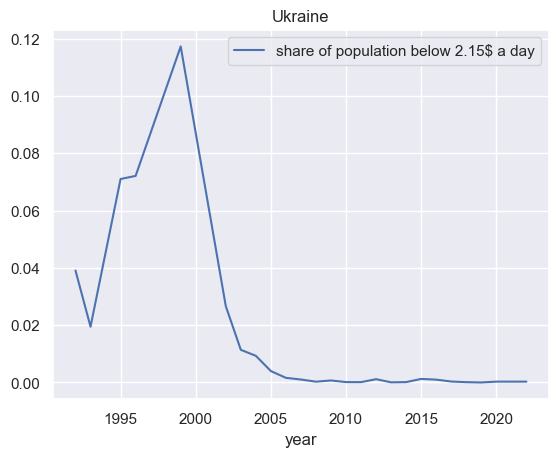

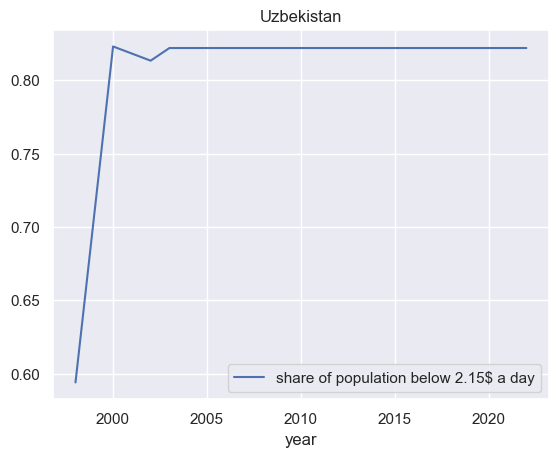

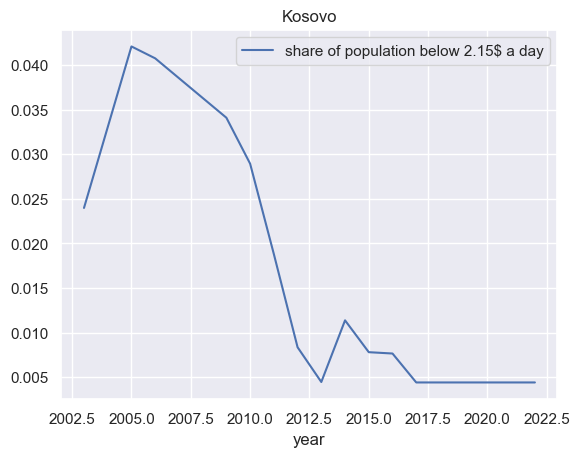

In [142]:
for country in df.loc[df['region_name'] == 'Europe & Central Asia', 'country_name'].unique():
    df.loc[df['country_name'] == country, ['year', 'share of population below 2.15$ a day']].plot(x='year', y='share of population below 2.15$ a day', title=country)

In [ ]:
df_le = pd.read_csv('dataset\life-expectancy.csv')
df_le

In [ ]:
df.isna().sum()

In [ ]:
df.drop(columns=['Total Population (thousands)'], inplace=True)

In [ ]:
df.groupby('year').sum(numeric_only=True).plot(y='Total Population (thousands)')